In [ ]:
import time
import random
!pip install unidecode
import unidecode
import string
import re

import matplotlib.pyplot as plt
import torch

torch.backends.cudnn.deterministic = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.8 MB/s eta 0:00:00


In [ ]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cpu')

TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

print('Device:', DEVICE)

Device: cpu


In [ ]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [ ]:
with open('shakespeare.txt', 'r') as f:
    textfile = f.read()

TEXT_LENGTH = len(textfile)

print(f'Number of characters in text: {TEXT_LENGTH}')

Number of characters in text: 4538523


In [ ]:
random.seed(RANDOM_SEED)

def random_portion(textfile):
    start_index = random.randint(0, TEXT_LENGTH - TEXT_PORTION_SIZE)
    end_index = start_index + TEXT_PORTION_SIZE + 1
    return textfile[start_index:end_index]

print(random_portion(textfile))

in some boats that are not steer'd .


The noise is round about us .

Let us from it .

What pleasure , sir , find we in life , to lock it 
From action and adventure ?

Nay , what hope 
Have we in hidi


In [ ]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def draw_random_sample(textfile):    
    text_long = char_to_tensor(random_portion(textfile))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

In [ ]:
draw_random_sample(textfile)

(tensor([20, 14, 28, 94, 30, 28, 94, 29, 17, 14, 23, 94, 15, 24, 27, 94, 15, 24,
         24, 21, 28, 94, 73, 96, 55, 24, 94, 29, 27, 34, 94, 18, 15, 94, 29, 17,
         10, 29, 94, 24, 30, 27, 94, 24, 32, 23, 94, 11, 14, 94, 24, 30, 27, 28,
         94, 24, 27, 94, 23, 24, 94, 75, 96, 96, 44, 94, 28, 25, 14, 10, 20, 94,
         23, 24, 29, 94, 29, 24, 94, 29, 17, 10, 29, 94, 27, 10, 18, 21, 18, 23,
         16, 94, 43, 14, 12, 10, 29, 14, 94, 73, 96, 37, 30, 29, 94, 30, 23, 29,
         24, 94, 29, 17, 14, 14, 94, 73, 94, 36, 21, 14, 23, 94, 24, 23, 94, 73,
         94, 10, 23, 13, 94, 29, 17, 14, 94, 27, 14, 28, 29, 94, 78, 96, 58, 18,
         21, 21, 94, 34, 14, 94, 73, 94, 21, 18, 20, 14, 94, 28, 24, 21, 13, 18,
         14, 27, 28, 94, 73, 94, 12, 24, 22, 14, 94, 10, 23, 13, 94, 15, 18, 16,
         17, 29, 94, 18, 29, 94, 24, 30, 29, 94, 82, 96, 96, 54, 18, 16, 23, 18,
         24, 27]),
 tensor([14, 28, 94, 30, 28, 94, 29, 17, 14, 23, 94, 15, 24, 27, 94, 15, 24, 24,
         

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        
        self.embed = torch.nn.Embedding(num_embeddings=input_size,
                                        embedding_dim=embed_size)
        self.rnn = torch.nn.LSTMCell(input_size=embed_size,
                                     hidden_size=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, character, hidden, cell_state):
        # expects character as size [batch_size, 1]
    
        # [batch size, embedding dim] = [1, embedding dim]
        embedded = self.embed(character)

        (hidden, cell_state) = self.rnn(embedded, (hidden, cell_state))
        # 1. output dim: [batch size, output_size] = [1, output_size]
        # 2. hidden dim: [batch size, hidden dim] = [1, hidden dim]
        # 3. cell dim: [batch size, hidden dim] = [1, hidden dim]

        output = self.fc(hidden)

        return output, hidden, cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = RNN(len(string.printable), EMBEDDING_DIM, HIDDEN_DIM, len(string.printable))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    ## based on https://github.com/spro/practical-pytorch/
    ## blob/master/char-rnn-generation/char-rnn-generation.ipynb

    (hidden, cell_state) = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        inp = prime_input[p].unsqueeze(0)
        _, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
    inp = prime_input[-1].unsqueeze(0)
    
    for p in range(predict_len):

        outputs, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
        
        # Sample from the network as a multinomial distribution
        output_dist = outputs.data.view(-1).div(temperature).exp() # e^{logits / T}
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

Time elapsed: 0.00 min
Iteration 0 | Loss 4.63


`!AqfpD]^lR2+mgugN\kM&|;p>@Ky`nxB>#9\G,YCL]K<Fe>nsOyv)D61an
#+#&b~T`-|>=2j(erZ,tz=LbQLBVp*iF\X2YrP+A=DM?Nzx}A#MNh"XrAWfJ7"jz {LS	"VAb'f:9KbE?tbpM2c{&! KrE@Ad
HK],hftT
~{NMf?pP5Cft^* 

Time elapsed: 0.36 min
Iteration 200 | Loss 2.09


Ther ,
Watle a I ferog buves the ot beat to hor ,
+ove me and conchake wostills bowe sond sore wile that be wand , as of mots my prou , he the that I cour at and hull buthe there ther hepe to swall you  

Time elapsed: 0.62 min
Iteration 400 | Loss 1.91


Thee an neatireed , two nit the hee with that stand the decher ? on siond , seany , and fir wen hey spast age my twers mustreent mithe a younteir , at laster sain theeis ; with tith a with , hender , ba 

Time elapsed: 0.89 min
Iteration 600 | Loss 2.02


Thar and you lousor my aan or brank'd in , bathering him this .

Shis bask in would ?


Be seree , her : mose the sporinver s'ber 'tien entor ligh'd the forn stor the shom here no you peit I this ses

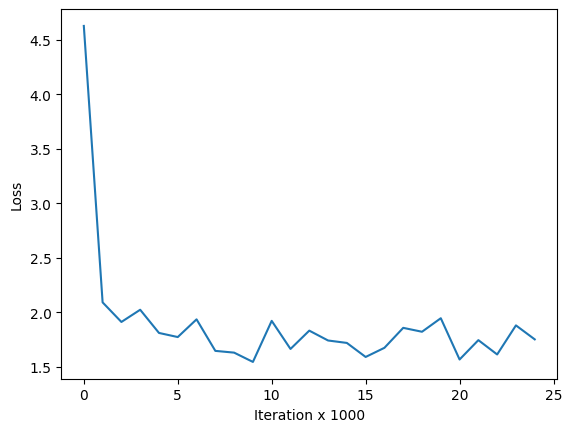

In [ ]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):

    hidden, cell_state = model.init_zero_state()
    optimizer.zero_grad()
    
    loss = 0.
    inputs, targets = draw_random_sample(textfile)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden, cell_state = model(inputs[c].unsqueeze(0), hidden, cell_state)
        loss += torch.nn.functional.cross_entropy(outputs, targets[c].view(1))

    loss /= TEXT_PORTION_SIZE
    loss.backward()


    ### UPDATE MODEL PARAMETERS
    optimizer.step()


    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            plt.savefig('loss1.pdf')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()

In [ ]:
## Calculating ACc

def calculate_accuracy(predictions, targets):
    correct = 0
    total = 0
    for pred, target in zip(predictions, targets):
        if pred == target:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy